# Task 2 - Model Building and Training 


**Loading the datasets for modeling**




In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Set max rows and columns to display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Configure logging
from logger import SetupLogger
# Assuming this class is defined in scripts/
from load_data import LoadData  

logger = SetupLogger(log_file='../logs/notebooks.log').get_logger()


Load the datasets

In [2]:
# Create instances
load_fraud = LoadData('../data/processed_fraud_data.csv', logger=logger)
load_credit = LoadData('../data/creditcard.csv', logger=logger)
# Load the datasets
fraud_data = load_fraud.load_dataset().set_index('user_id')
credit_data = load_credit.load_dataset()



In [ ]:
# Explore the few rows
credit_data.head()

In [ ]:
fraud_data.head()

In [ ]:
# Understand the shapes
credit_data.shape, fraud_data.shape

In [ ]:
# Check any missing values
print(credit_data.isnull().sum())
print(fraud_data.isnull().sum())

**Data Preparation:**

- Feature and Target Separation [‘Class’(creditcard), ‘class’(Fraud_Data)]
Train-Test Split 

For creditcard dataset (target column 'Class'):

In [3]:
from data_preparation import DataPreparation
# Assuming df_creditcard is the DataFrame for the credit card dataset
_creditcard = DataPreparation(credit_data, target_column='Class')
_creditcard.train_test_split(test_size=0.2, random_state=42)

# Retrieving the train and test sets
X_train_cc, X_test_cc, y_train_cc, y_test_cc = _creditcard.get_train_test_data()


Data split into training and testing sets successfully.


For Fraud_Data dataset (target column 'class'):

In [4]:
# Assuming df_fraud is the DataFrame for the fraud dataset
_fraud = DataPreparation(fraud_data, target_column='class')
_fraud.train_test_split(test_size=0.2, random_state=42)

# Retrieving the train and test sets
X_train_fd, X_test_fd, y_train_fd, y_test_fd = _fraud.get_train_test_data()


Data split into training and testing sets successfully.


In [12]:
X_test_fd.iloc[8:9]
-0.48764,-0.247051,-1.090207,-1.231124,	-0.505034,	0.121794,0.0,-0.259874,	-0.232943,0.0,	1.0,	0.0,	0.0,	0.0,	0.0,	1.0

,purchase_value,age,purchase_delay,hour_of_day,day_of_week,fraud_rate,user_transaction_frequency,device_transaction_frequency,user_transaction_velocity,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
user_id,,,,,,,,,,,,,,,,
120002,-0.48764,-0.247051,-1.090207,-1.231124,-0.505034,0.121794,0.0,-0.259874,-0.232943,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Model Selection
- Import ModelPipeline class from model_pipeline
- Train multiple models
- hyperparameter tune
- evaluate the model
- compare the model

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Disable CUDA

# Import the class
from model_pipeline import ModelPipeline

**Train and Evaluate the models on the e-commerce fruad dataset**


In [ ]:
# Create instance of the pipeline
model_pipeline = ModelPipeline(X_train_fd, X_test_fd, y_train_fd, y_test_fd)

# add models
# model_pipeline.add_models()
# Train and evaluate, logging with MLflow
best_model, best_model_name = model_pipeline.train_and_evaluate()
# Save the best model
model_pipeline.save_best_models(best_model, best_model_name, 'fraud')

In [ ]:
# Get the results 
results_fraud, y_probs_fraud = model_pipeline.get_results()


In [ ]:
pd.DataFrame(results_fraud).T

**Train and Evaluate the models on the creditcard dataset**


In [ ]:
# Create instance of the pipeline
model_pipeline = ModelPipeline(X_train_cc, X_test_cc, y_train_cc, y_test_cc)

# add models
model_pipeline.add_models()
# Train and evaluate, logging with MLflow
best_model, best_model_name = model_pipeline.train_and_evaluate()
# Save the best model
model_pipeline.save_best_models(best_model, best_model_name, 'creditcard')

In [ ]:
# Get the results 
results_creditcard, y_probs_credicard = model_pipeline.get_results()

In [ ]:
pd.DataFrame(results_creditcard).T

**Note:** Model training and evaluation have been completed, with all processes tracked using MLflow. Please refer to the document for screenshots showcasing the tracked models across different versions.

## Task 3 - Model Explainability

Model explainability is crucial for understanding, trust, and debugging in machine learning models. I will use SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations) to interpret the models I built for fraud detection.



Using SHAP and LIME for Explainability of the model trained with E-commerce dataset

In [22]:
import joblib 
model = joblib.load('../app/random_forest_fraud_best_model.pkl')  # Load the saved model

In [7]:
model

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(max_depth=5))])

In [11]:
type(model)

sklearn.pipeline.Pipeline

In [23]:
import shap

In [25]:
model = model.steps[-1][1]

In [26]:
# Create SHAP explainer
explainer = shap.TreeExplainer(model)

In [9]:
explainer

In [27]:
# Calculate SHAP values for all samples
shap_values = explainer.shap_values(X_test_fd)

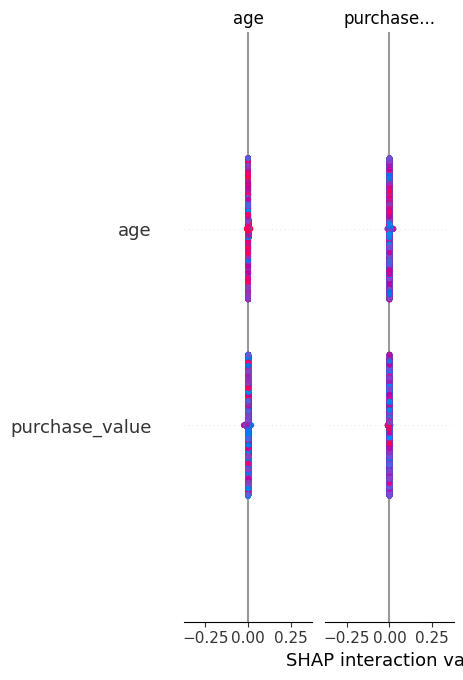

In [29]:
shap.summary_plot(shap_values, X_test_fd, show=True)

In [30]:
import shap
shap.initjs()


In [31]:
# Sample only a small number of rows, such as the top 100 samples
sample_indices = shap_values[0:100]  # Adjust the range based on your dataset

# Choose a specific index from the subsample
sample_index = 1  # Update this based on the index you want

# Plot SHAP force plot for the subsampled data
shap.plots.force(explainer.expected_value[sample_index], shap_values[sample_index])


In [39]:
import shap
import joblib
import pandas as pd
from lime import lime_tabular
import matplotlib.pyplot as plt
shap.initjs()

class ModelExplainer:
    """
    A class for explaining machine learning models using SHAP and LIME.

    Attributes:
    -----------
    model : object
        The trained machine learning model.
    X_test : DataFrame
        The test dataset to explain.

    Methods:
    ----------
    __init__(self, model_path, X_test):
        Initializes the class with the model and test dataset paths.
    
    explain_with_shap(self, instance_idx=0):
        Generates SHAP Summary Plot, Force Plot, and Dependence Plot for the given model.
    
    explain_with_lime(self, instance_idx=0):
        Generates LIME Feature Importance Plot for a single instance of the dataset.
    
    explain_model(self, instance_idx=0):
        Runs both SHAP and LIME explainability functions on the model and dataset.
    """

    def __init__(self, model_path, X_test):
        """
        Initialize the ModelExplainer class with the model and test dataset.

        Parameters:
        -----------
        model_path : str
            The path to the saved model file (e.g., .pkl).
        X_test : DataFrame
            The test dataset (in pandas DataFrame format).
        """
        self.model = joblib.load(model_path)  # Load the saved model
        self.X_test = X_test  # Load the test dataset

        # If the model is part of a scikit-learn pipeline, extract the last model from the pipeline
        if hasattr(self.model, 'steps'):
            self.model = self.model.steps[-1][1]  # Extract the model from the last step of the pipeline

    def explain_with_shap(self, instance_idx=0):
        """
        Generate SHAP Summary Plot, Force Plot, and Dependence Plot for the model.

        Parameters:
        -----------
        instance_idx : int, optional (default=0)
            The index of the instance to explain with SHAP Force Plot.
        """
        print("Generating SHAP explanations...")

        # Create SHAP explainer
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.X_test)
        
        # SHAP Summary Plot: Overview of important features
        plt.figure(figsize=(15, 4))
        shap.summary_plot(shap_values, self.X_test, show=False)
        plt.title('SHAP Summary Plot')
        plt.show()
        
        # Sample only a small number of rows, such as the top 100 samples
        sample_indices = shap_values[0:100]  # Adjust the range based on your dataset

        # Choose a specific index from the subsample
        sample_index = 1  # Update this based on the index you want

        # Plot SHAP force plot for the subsampled data
        shap.plots.force(explainer.expected_value[sample_index], shap_values[sample_index])
        plt.show()
        # # SHAP Dependence Plot: Relationship between feature and model output
        # shap.dependence_plot(self.X_test.columns[0], shap_values_to_use, self.X_test, show=False)
        # plt.title(f'SHAP Dependence Plot for Feature: {self.X_test.columns[0]}')
        # plt.show()



    def explain_with_lime(self, instance_idx=0):
        """
        Generate LIME Feature Importance Plot for a single instance of the dataset.

        Parameters:
        -----------
        instance_idx : int, optional (default=0)
            The index of the instance to explain with LIME.
        """
        print("Generating LIME explanations...")

        # Create LIME explainer
        explainer_lime = lime_tabular.LimeTabularExplainer(
            training_data=self.X_test.values, 
            feature_names=self.X_test.columns, 
            mode='classification'
        )

        # Select a single instance (default: first instance)
        instance = self.X_test.iloc[instance_idx].values
        explanation = explainer_lime.explain_instance(instance, self.model.predict_proba)

        # Display LIME Feature Importance Plot
        explanation.as_pyplot_figure()
        plt.title(f'LIME Feature Importance for Instance {instance_idx}')
        plt.show()

    def explain_model(self, instance_idx=0):
        """
        Run both SHAP and LIME explainability methods for the model.

        Parameters:
        -----------
        instance_idx : int, optional (default=0)
            The index of the instance to explain with LIME and SHAP.
        """
        # Explain the model with SHAP and LIME for the specified instance
        self.explain_with_shap(instance_idx)
        self.explain_with_lime(instance_idx)


Generating SHAP explanations...


<Figure size 1500x400 with 0 Axes>

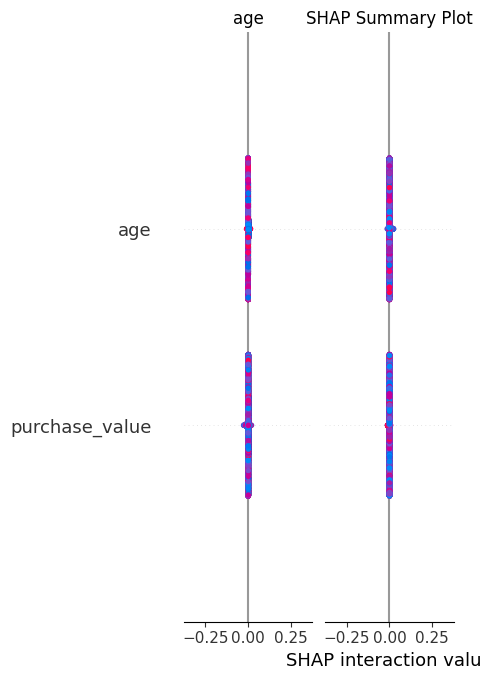

Generating LIME explanations...


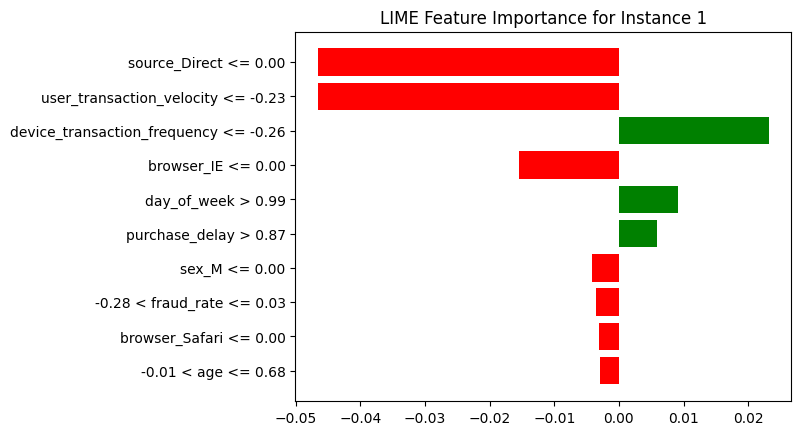

Generating SHAP explanations...


<Figure size 1500x400 with 0 Axes>

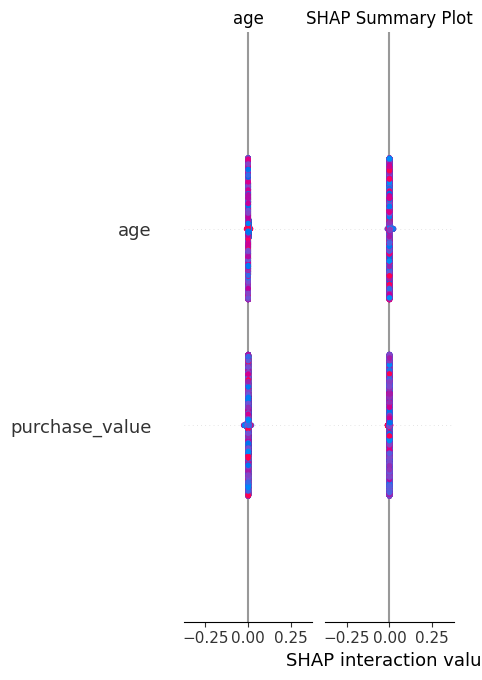

Generating LIME explanations...


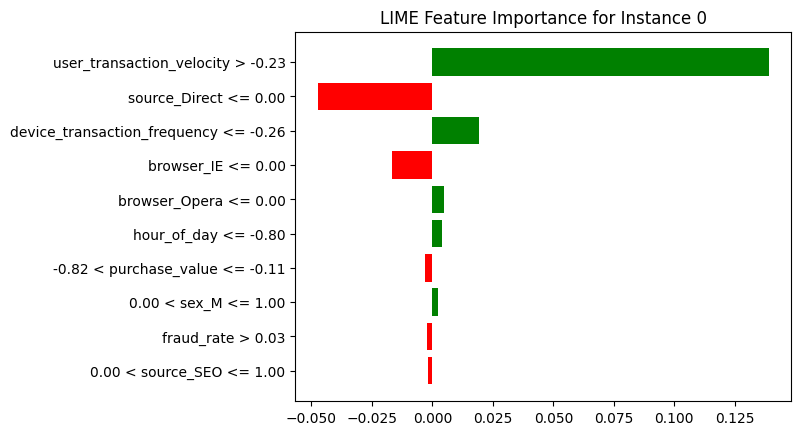

In [42]:
# # Import neccessary modules
# from model_explainer import ModelExplainer

# Create instance of the class
fraud_explainer = ModelExplainer('../app/random_forest_fraud_best_model.pkl', X_test_fd)

 # Explains the first instance in the dataset
fraud_explainer.explain_model(instance_idx=1) 
 # Explains the first instance in the dataset
fraud_explainer.explain_model(instance_idx=0) 

In [6]:
import shap
print(shap.__version__)


0.46.0
